Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz
Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x1a36630b90>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x1a36630750>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x1a393b2a10>)


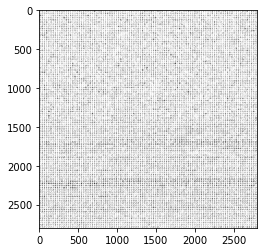

In [6]:
#get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from tensorflow.examples.tutorials.mnist import input_data

# PROJECTOR需要的日志文件名和地址相关参数
LOG_DIR = 'log'
SPRITE_FILE = 'mnist_sprite.jpg'
META_FIEL = "mnist_meta.tsv"


# 使用给出的MNIST图片列表生成sprite图像
def create_sprite_image(images):
    """Returns a sprite image consisting of images passed as argument. Images should be count x width x height"""
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    # sprite图像可以理解成是小图片平成的大正方形矩阵，大正方形矩阵中的每一个元素就是原来的小图片。于是这个正方形的边长就是sqrt(n),其中n为小图片的数量。
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))

    # 使用全1来初始化最终的大图片。
    spriteimage = np.ones((img_h*n_plots, img_w*n_plots))

    for i in range(n_plots):
        for j in range(n_plots):
            # 计算当前图片的编号
            this_filter = i*n_plots + j
            if this_filter < images.shape[0]:
                # 将当前小图片的内容复制到最终的sprite图像
                this_img = images[this_filter]
                spriteimage[i*img_h:(i + 1)*img_h,
                j*img_w:(j + 1)*img_w] = this_img

    return spriteimage


# 加载MNIST数据。这里指定了one_hot=False,于是得到的labels就是一个数字，表示当前图片所表示的数字。
mnist = input_data.read_data_sets("./MNIST_data", one_hot=False)
print(mnist)
# 生成sprite图像
to_visualise = 1 - np.reshape(mnist.test.images, (-1, 28, 28))
# print(to_visualise)
sprite_image = create_sprite_image(to_visualise)

# 将生成的sprite图片放到相应的日志目录下
path_for_mnist_sprites = os.path.join(LOG_DIR, SPRITE_FILE)
plt.imsave(path_for_mnist_sprites, sprite_image, cmap='gray')
plt.imshow(sprite_image, cmap='gray')

# 生成每张图片对应的标签文件并写道相应的日志目录下
path_for_mnist_metadata = os.path.join(LOG_DIR, META_FIEL)
with open(path_for_mnist_metadata, 'w') as f:
    f.write("Index\tLabel\n")
    for index, label in enumerate(mnist.test.labels):
        f.write("%d\t%d\n"%(index, label))

In [7]:
import tensorflow as tf
import mnist_inference
import os
import tqdm

# 加载用于生成PROJECTOR日志的帮助函数
from tensorflow.contrib.tensorboard.plugins import projector
from tensorflow.examples.tutorials.mnist import input_data

BATCH_SIZE = 100
LEARNING_RATE_BASE = 0.8
LEARNING_RATE_DECAY = 0.99
REGULARIZATION_RATE = 0.0001
TRAINING_STEPS = 10000
MOVING_AVERAGE_DECAY = 0.99

LOG_DIR = 'log_2'
SPRITE_FILE = 'mnist_sprite.jpg'
META_FIEL = "mnist_meta.tsv"
TENSOR_NAME = "FINAL_LOGITS"


# 这里需要返回最后测试数据经过整个神经网络得到的输出层矩阵，因为有多张测试图片，每张图片对应了一个输出层向量。所以返回的结果是这些向量组成的矩阵。
def train(mnist):
    #  输入数据的命名空间。
    with tf.name_scope('input'):
        x = tf.placeholder(tf.float32, [None, mnist_inference.INPUT_NODE], name='x-input')
        y_ = tf.placeholder(tf.float32, [None, mnist_inference.OUTPUT_NODE], name='y-input')
    regularizer = tf.contrib.layers.l2_regularizer(REGULARIZATION_RATE)
    y = mnist_inference.inference(x, regularizer)
    global_step = tf.Variable(0, trainable=False)

    # 处理滑动平均的命名空间。
    with tf.name_scope("moving_average"):
        variable_averages = tf.train.ExponentialMovingAverage(MOVING_AVERAGE_DECAY, global_step)
        variables_averages_op = variable_averages.apply(tf.trainable_variables())

    # 计算损失函数的命名空间。
    with tf.name_scope("loss_function"):
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=y, labels=tf.argmax(y_, 1))
        cross_entropy_mean = tf.reduce_mean(cross_entropy)
        # 由于使用L2正则化，此处需要加上'losses'集合
        loss = cross_entropy_mean + tf.add_n(tf.get_collection('losses'))

    # 定义学习率、优化方法及每一轮执行训练的操作的命名空间。
    with tf.name_scope("train_step"):
        learning_rate = tf.train.exponential_decay(
            LEARNING_RATE_BASE,
            global_step,
            mnist.train.num_examples/BATCH_SIZE, LEARNING_RATE_DECAY,
            staircase=True)

        train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
        # 由于使用了滑动平均方法，所以在反向传播时也要更新可训练变量的滑动平均值
        with tf.control_dependencies([train_step, variables_averages_op]):
            train_op = tf.no_op(name='train')

    # 训练模型。
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        for i in tqdm.tqdm(range(TRAINING_STEPS)):
            xs, ys = mnist.train.next_batch(BATCH_SIZE)
            _, loss_value, step = sess.run([train_op, loss, global_step], feed_dict={x: xs, y_: ys})

            if i%1000 == 0:
                print("After %d training step(s), loss on training batch is %g."%(i, loss_value))
        # 计算MNIST测试数据对应的输出层矩阵
        final_result = sess.run(y, feed_dict={x: mnist.test.images})
    # 返回输出层矩阵的值
    return final_result


# 生成可视化最终输出层向量所需要的日志文件
def visualisation(final_result):
    # 使用一个新的变量来保存最终输出层向量的结果，因为embedding是通过Tensorflow中变量完成的，所以PROJECTOR可视化的都是TensorFlow中的变哇。
    # 所以这里需要新定义一个变量来保存输出层向量的取值
    y = tf.Variable(final_result, name=TENSOR_NAME)
    summary_writer = tf.summary.FileWriter(LOG_DIR)

    # 通过project.ProjectorConfig类来帮助生成日志文件
    config = projector.ProjectorConfig()
    # 增加一个需要可视化的bedding结果
    embedding = config.embeddings.add()
    # 指定这个embedding结果所对应的Tensorflow变量名称
    embedding.tensor_name = y.name

    # Specify where you find the metadata
    # 指定embedding结果所对应的原始数据信息。比如这里指定的就是每一张MNIST测试图片对应的真实类别。在单词向量中可以是单词ID对应的单词。
    # 这个文件是可选的，如果没有指定那么向量就没有标签。
    embedding.metadata_path = META_FIEL

    # Specify where you find the sprite (we will create this later)
    # 指定sprite 图像。这个也是可选的，如果没有提供sprite 图像，那么可视化的结果
    # 每一个点就是一个小困点，而不是具体的图片。
    embedding.sprite.image_path = SPRITE_FILE
    # 在提供sprite图像时，通过single_image_dim可以指定单张图片的大小。
    # 这将用于从sprite图像中截取正确的原始图片。
    embedding.sprite.single_image_dim.extend([28, 28])

    # Say that you want to visualise the embeddings
    # 将PROJECTOR所需要的内容写入日志文件。
    projector.visualize_embeddings(summary_writer, config)

    # 生成会话，初始化新声明的变量并将需要的日志信息写入文件。
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.save(sess, os.path.join(LOG_DIR, "model"), TRAINING_STEPS)

    summary_writer.close()


# 主函数先调用模型训练的过程，再使用训练好的模型来处理MNIST测试数据，
# 最后将得到的输出层矩阵输出到PROJECTOR需要的日志文件中。
def main(argv=None):
    mnist = input_data.read_data_sets("./MNIST_data", one_hot=True)
    final_result = train(mnist)
    visualisation(final_result)


if __name__ == '__main__':
    main()

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


  1%|          | 124/10000 [00:00<18:47,  8.76it/s]

After 0 training step(s), loss on training batch is 2.53706.


 11%|█         | 1058/10000 [00:02<00:19, 461.36it/s]

After 1000 training step(s), loss on training batch is 0.242454.


 21%|██        | 2111/10000 [00:04<00:13, 603.95it/s]

After 2000 training step(s), loss on training batch is 0.164934.


 31%|███       | 3092/10000 [00:05<00:12, 569.25it/s]

After 3000 training step(s), loss on training batch is 0.134416.


 40%|████      | 4049/10000 [00:07<00:12, 482.45it/s]

After 4000 training step(s), loss on training batch is 0.148807.


 51%|█████     | 5090/10000 [00:10<00:11, 422.47it/s]

After 5000 training step(s), loss on training batch is 0.1112.


 60%|██████    | 6049/10000 [00:12<00:07, 526.24it/s]

After 6000 training step(s), loss on training batch is 0.120706.


 71%|███████   | 7088/10000 [00:14<00:05, 570.41it/s]

After 7000 training step(s), loss on training batch is 0.0816062.


 81%|████████  | 8098/10000 [00:16<00:03, 560.45it/s]

After 8000 training step(s), loss on training batch is 0.0817574.


 91%|█████████ | 9061/10000 [00:18<00:01, 525.16it/s]

After 9000 training step(s), loss on training batch is 0.0771691.


100%|██████████| 10000/10000 [00:20<00:00, 494.51it/s]


In [10]:
tensorboard --logdir=./log_2


SyntaxError: invalid syntax (<ipython-input-10-a1fbc5c06ec1>, line 1)